# Analyze`TedSim` grid-search results (w/ replicates) 

Application of `moslin` on `TedSim` simulations [[PHX-22]](https://doi.org/10.1093/nar/gkac235).


# Preliminaries

## Import packages

In [1]:
import sys
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import utils_run
from utils_analysis import state_tree_draw, tree_draw, plot_cost, node_colors

import moscot as mc

In [2]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

In [3]:
mc.__version__

'0.2.1.dev7+g00b5161'

## Dependencies

Run `data_generation` and `experiments` according to the instructions in the README

## Set up paths

Define the paths for data and figures

In [4]:
sys.path.insert(
    0, "../../../"
)  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

FIG_DIR = FIG_DIR / "simulations/pan_tedsim"
DATA_DIR = DATA_DIR / "simulations/pan_tedsim"

## Set global parameters

In [5]:
import mplscience

mplscience.set_style()
plt.rcParams["legend.scatterpoints"] = 1
plt.rcParams["figure.dpi"] = 300

# Visualize Tedsim simulation

In [6]:
adata = sc.read(DATA_DIR / "adata_0.4_0.4_12102.h5ad")

Only considering the two last: ['.4_12102', '.h5ad'].
Only considering the two last: ['.4_12102', '.h5ad'].



We can visualize the state tree the cells were sampled from

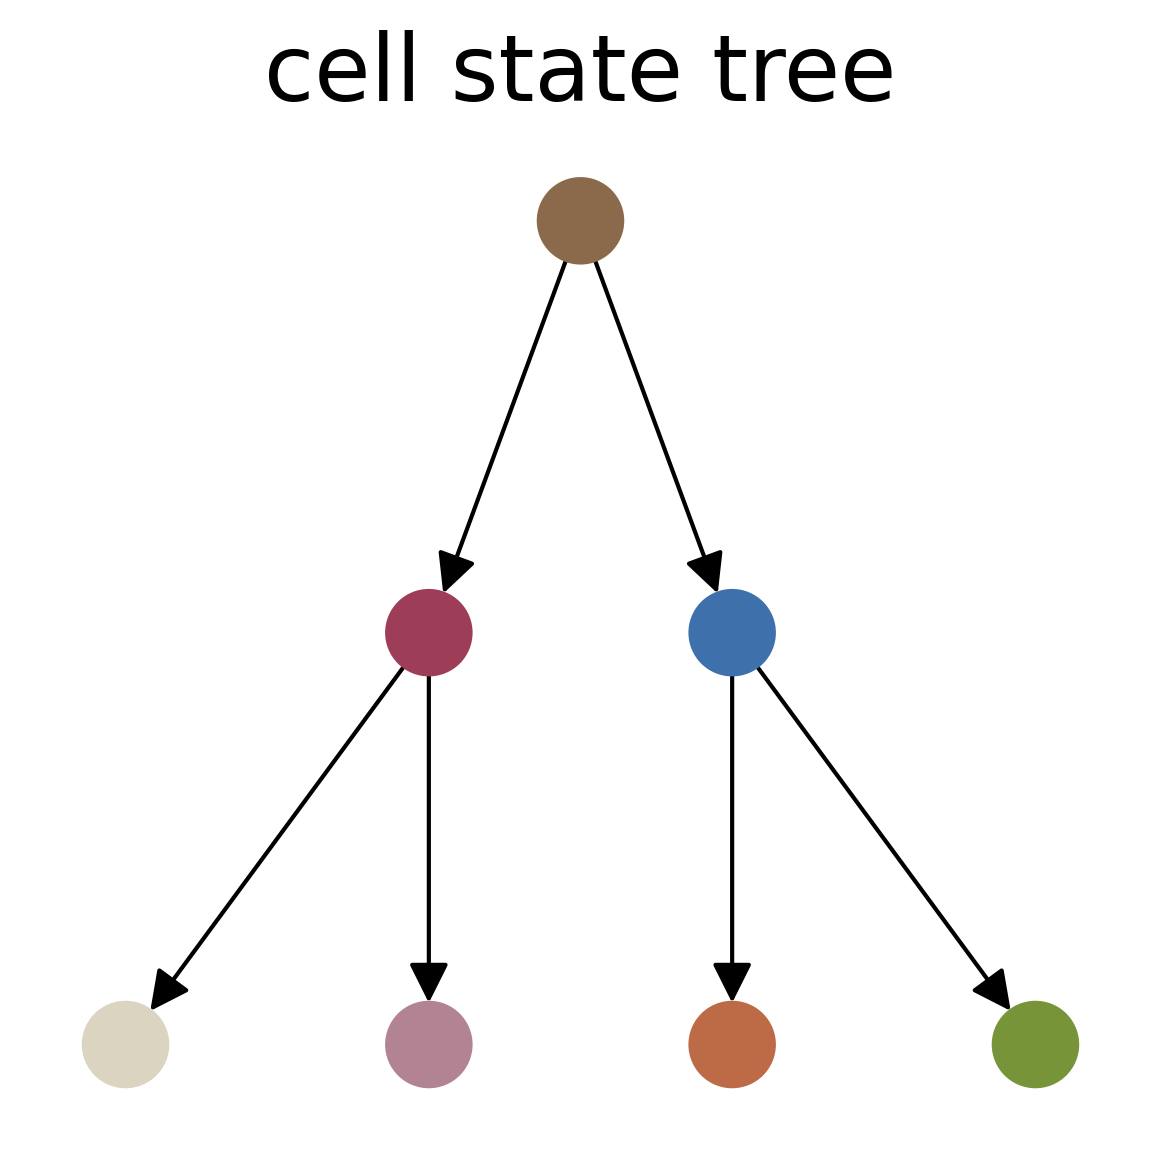

In [7]:
state_tree_draw(state_tree="((t1:2, t2:2):1, (t3:2, t4:2):1):2;", path=str(FIG_DIR))

And the actual simulated tree.<br>
For the purpose of visualizations we focus only the early tree (up to depth 8 in the simulation).

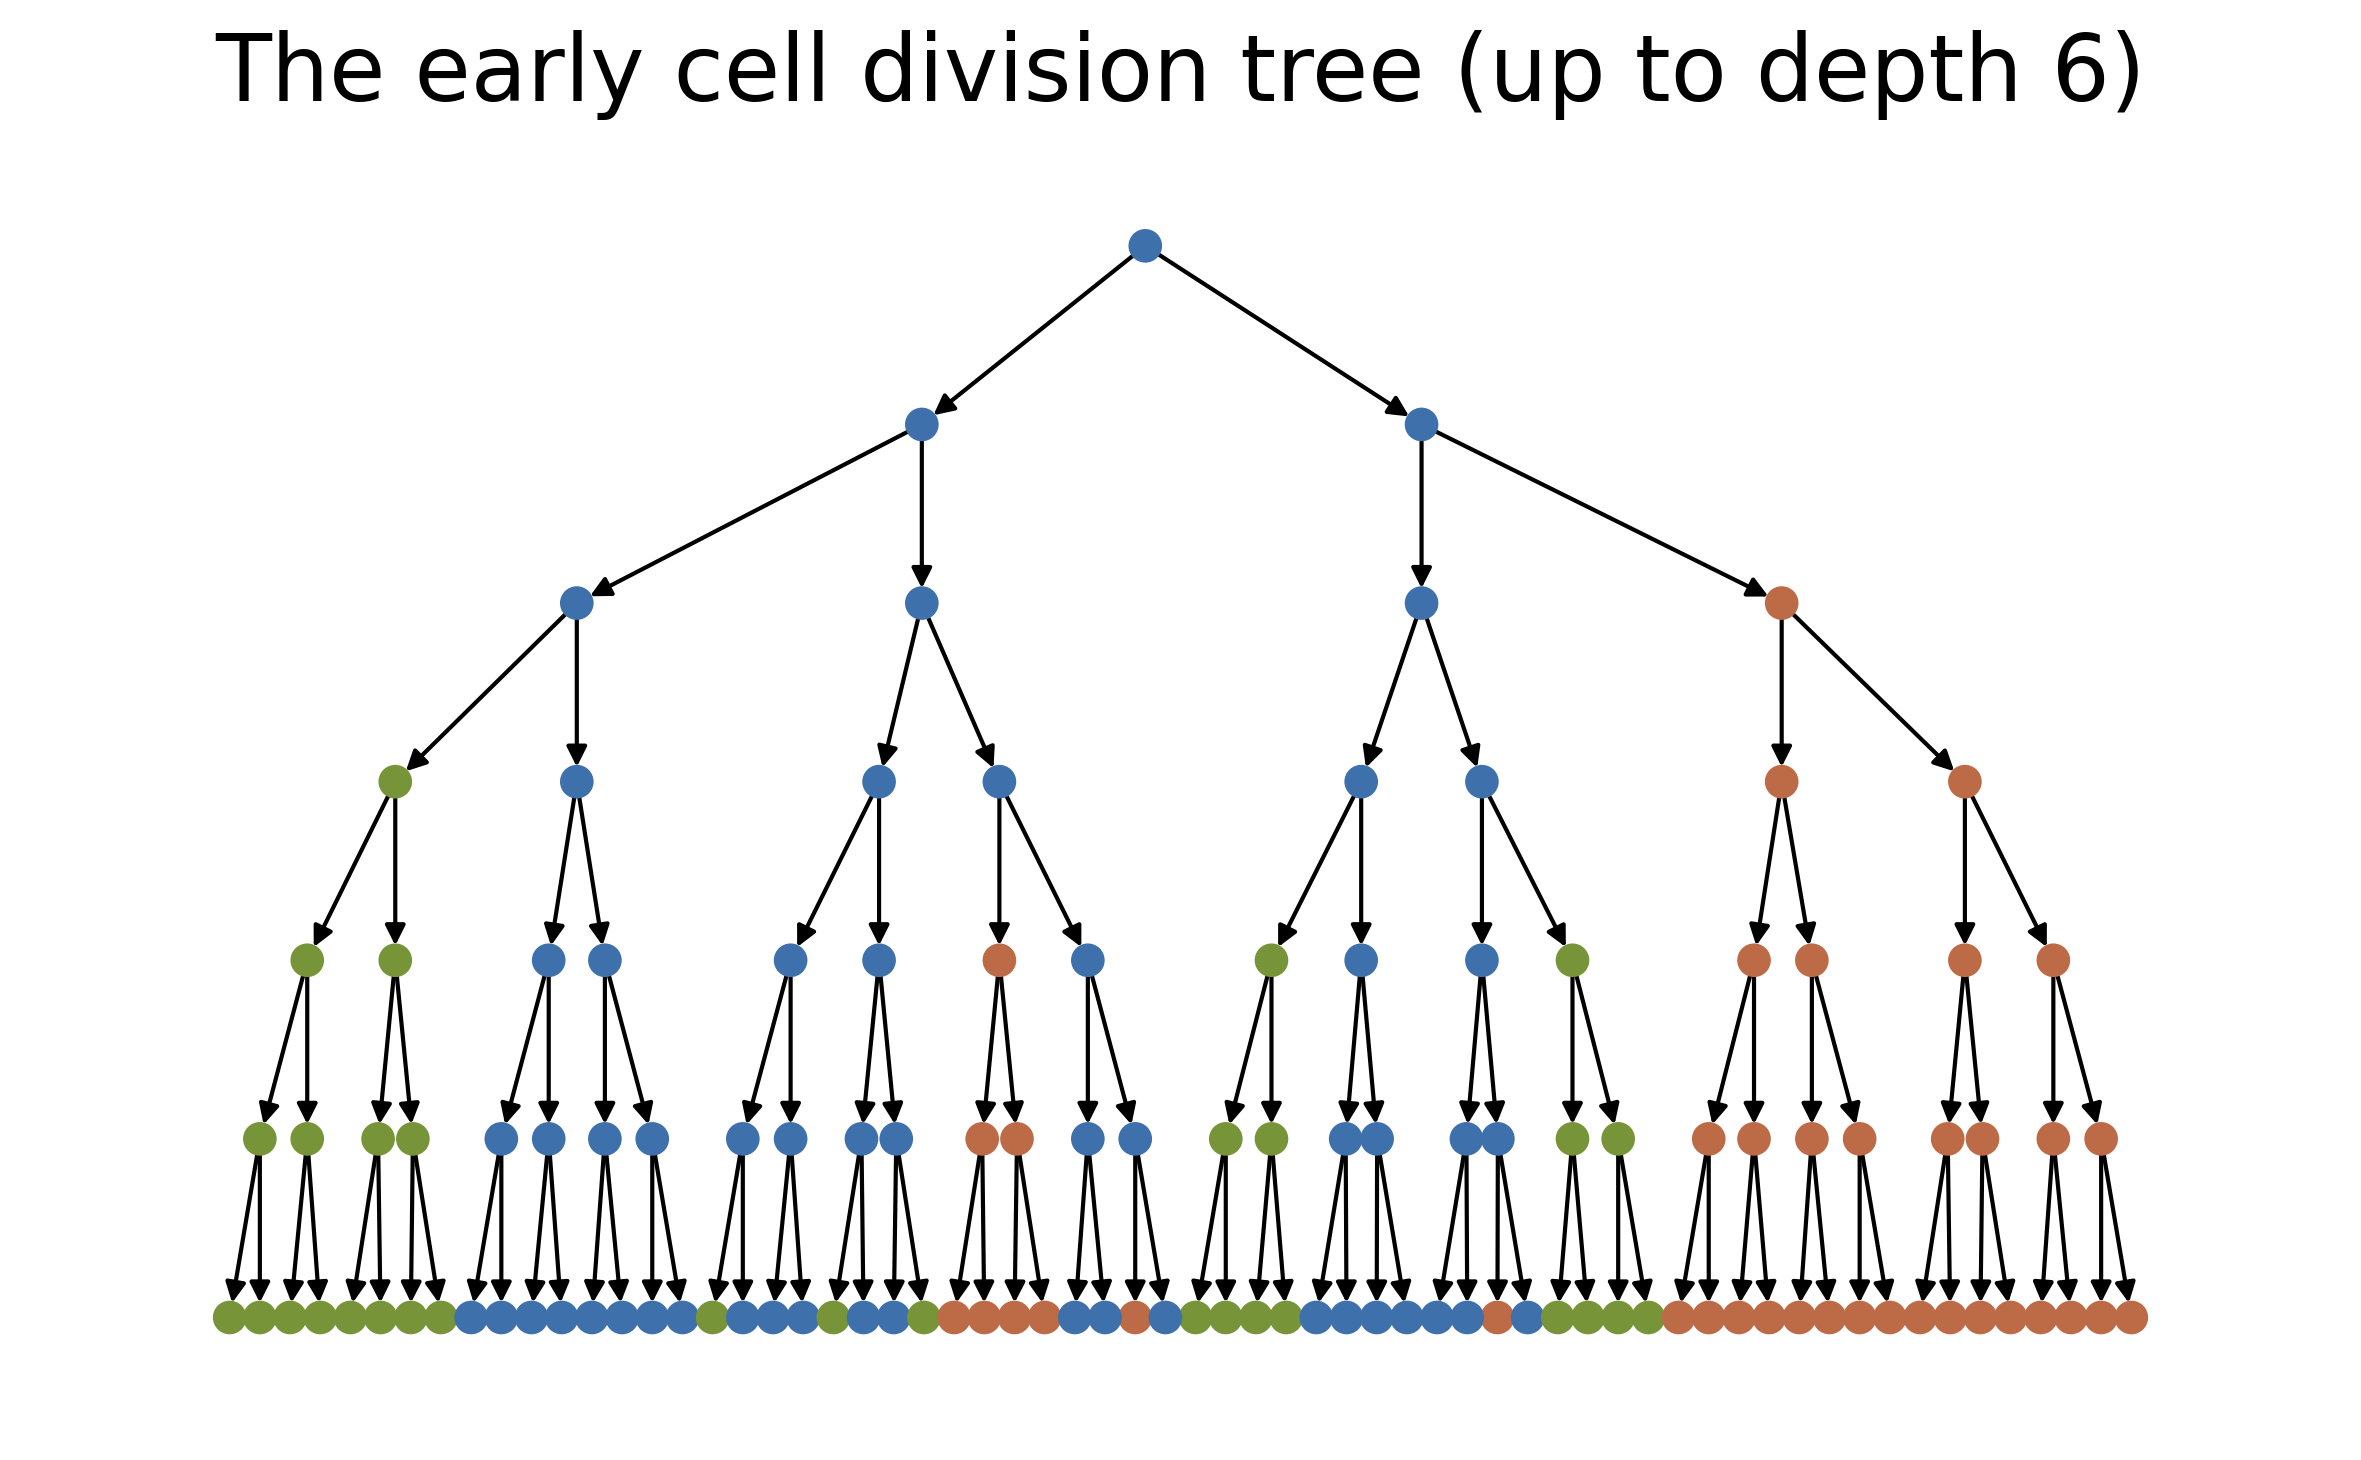

In [8]:
tree_draw(adata, depth=6, path=str(FIG_DIR))

We can see that cell's state obeys underlying cell state tree. <br>
For each cell the descendants are either of the same state or of a valid descendant based on the cell state tree.

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=30)
sc.tl.umap(adata)

In [10]:
adata.uns["cluster_colors"] = [
    node_colors[c] for c in adata.obs["cluster"].cat.categories
]

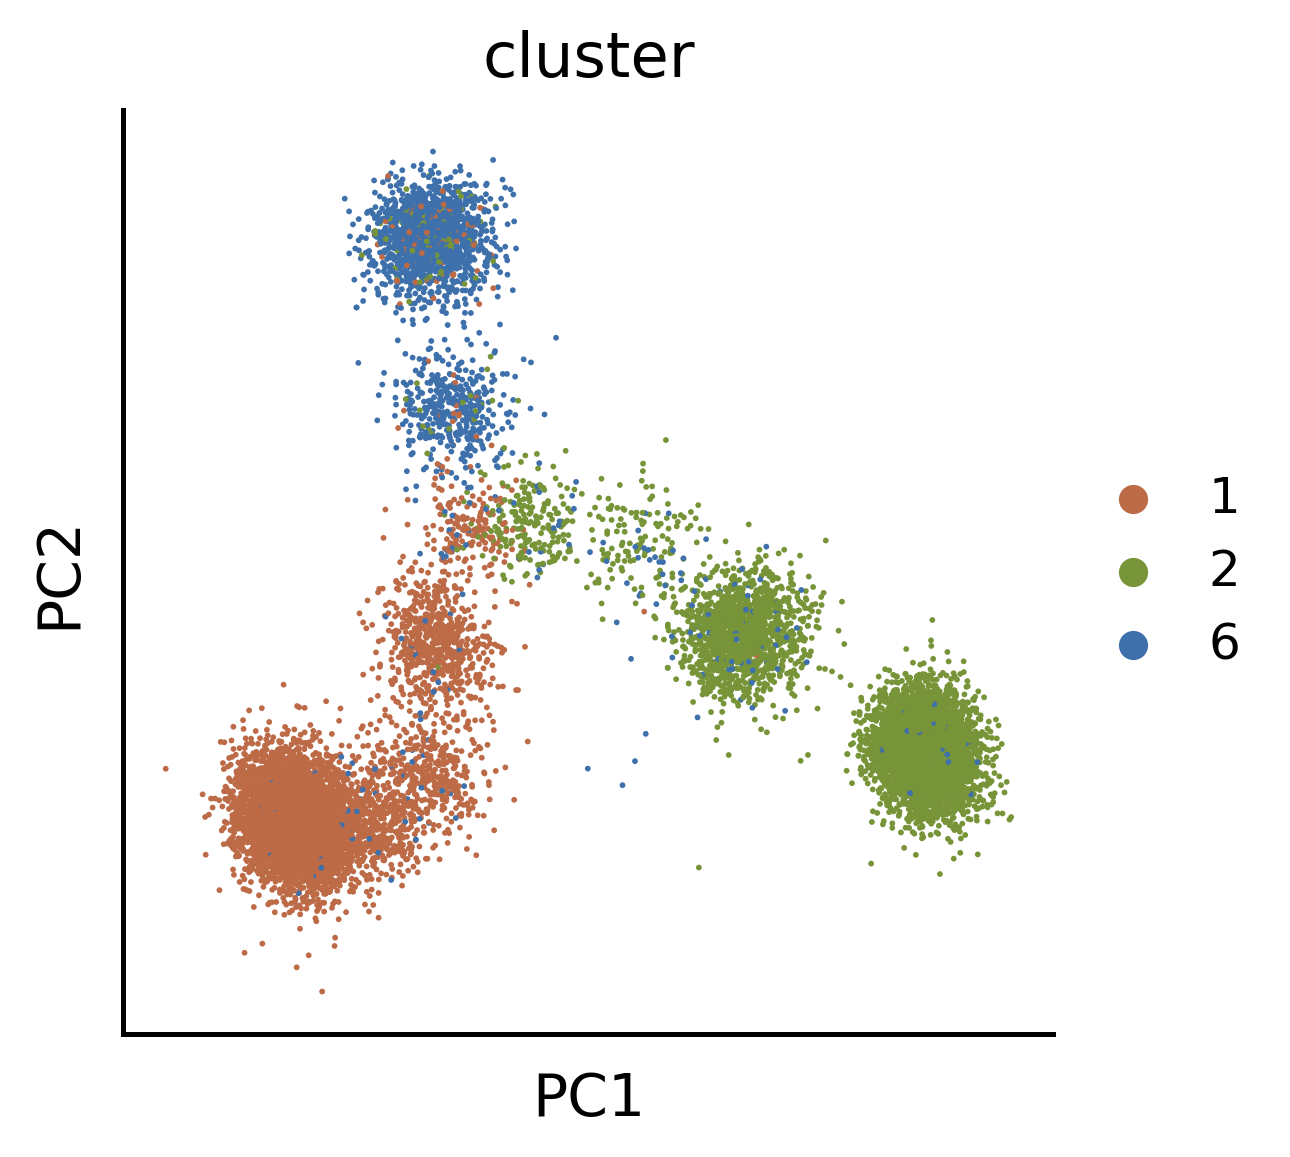

In [11]:
sc.pl.pca(adata[adata.obs["cluster"].isin([1, 2, 6])], color="cluster", show=False)
plt.savefig(
    FIG_DIR / "cluster_graph.png", bbox_inches="tight", transparent=True, dpi=300
)
plt.show()

# Import grid search results

In [12]:
df_moslin = pd.read_csv(DATA_DIR / "tedsim_moslin.csv")
df_lot = pd.read_csv(DATA_DIR / "tedsim_lot.csv")
df = pd.concat([df_moslin, df_lot])

In [13]:
df["config.kind"] = df["config.kind"].replace(
    ["moscot", "lot"], ["moslin", "LineageOT"]
)
df["config.ssr"] = df["config.ssr"].fillna(0)

df = df.drop(
    [
        "Unnamed: 0",
        "_id",
        "config.overwrite",
        "config.db_collection",
        "config.depth",
        "config.scale_cost",
        "result.scale_cost",
        "result.depth",
        "result.rank",
        "result.tree_type",
        "result.p_a",
        "result.ss",
        "result.seed",
        "result.ssr",
        "result.kind",
        "config.log2_n_cells",
        "result",
        "result.data_seed",
        "result.seed",
        "result.epsilon",
        "result.alpha",
    ],
    axis=1,
)

df = df[df["result.converged"] == True]

df["result.mean_cost"] = (
    df["result.early_cost"].astype(float) + df["result.late_cost"].astype(float)
) / 2

cols = [
    "config.p_a",
    "config.ssr",
    "config.ss",
    "config.kind",
    "config.alpha",
    "config.epsilon",
]

df_mean = df.groupby(cols).agg({"result.mean_cost": ["mean", "min", "std"]})
df_mean = df_mean.reset_index()
df_mean.columns = df_mean.columns.droplevel()
df_mean = df_mean.set_axis([*cols, "cost_mean", "cost_min", "cost_std"], axis=1)

idx = (
    df.groupby(
        ["config.p_a", "config.ssr", "config.ss", "config.kind", "config.data_seed"]
    )["result.mean_cost"].transform(min)
    == df["result.mean_cost"]
)

df_min = df[idx]

## Plot res

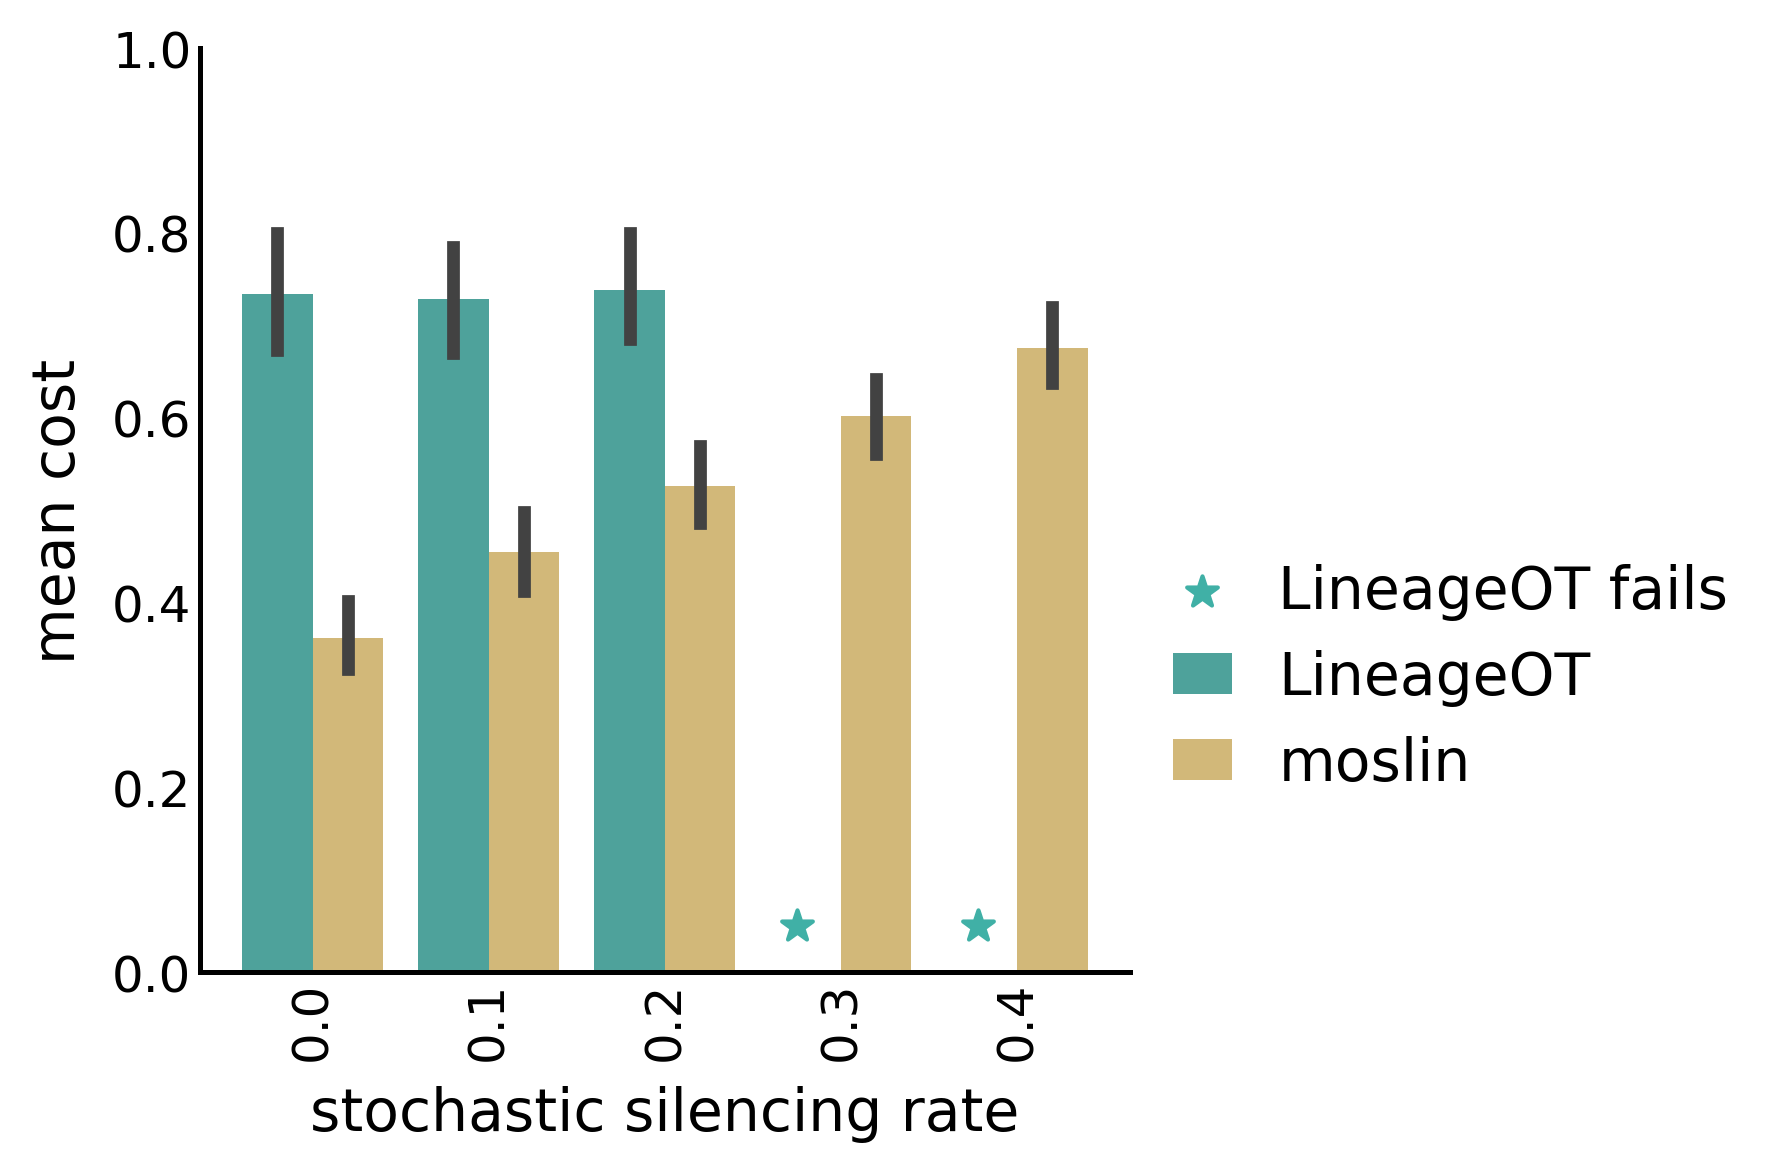

In [14]:
p_a = 0.4
step_size = 0.4
df_min_ss = df_min[df_min["config.ss"] == step_size]
ssrs = np.sort(df_min_ss["config.ssr"].unique())
hue_order = ["LineageOT", "moslin"]
method_colors = {
    "moslin": "#E1BE6A",
    "GW": "#117733",
    "OT": "#88CCEE",
    "LineageOT": "#40B0A6",
}

fontsize = 14

rows = 1
cols = len(ssrs)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

colors = {method: method_colors[method] for method in hue_order}
ax = sns.barplot(
    x="config.ssr",
    y="result.mean_cost",
    hue="config.kind",
    hue_order=hue_order,
    data=df_min_ss,
    ax=axs,
    palette=colors,
)

plt.scatter(
    x=[2.75, 3.78],
    y=[0.05, 0.05],
    marker="*",
    s=60,
    label="LineageOT fails",
    color=colors["LineageOT"],
)


ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("stochastic silencing rate")
ax.set_ylabel("mean cost", fontsize=fontsize)
ax.set_ylim(0, 1)
ax.legend(
    ncol=1,
    handlelength=1,
    fontsize=fontsize,
    # labelspacing=0.1,
    columnspacing=1,
    loc="upper right",
    bbox_to_anchor=(1.2, 0.0, 0.5, 0.5),
)
ax.tick_params(axis="both", which="both", length=0)

plt.savefig(
    FIG_DIR / "ssr_ss0.4_pa0.4.png", bbox_inches="tight", transparent=True, dpi=300
)

plt.show()

# References


[[PHX-22] Pan, X., Li, H., & Zhang, X. (2022). TedSim: temporal dynamics simulation of single-cell RNA sequencing data and cell division history. Nucleic Acids Research, 50(8), 4272-4288.](https://doi.org/10.1093/nar/gkac235)